# K-means

### Implémentation


In [16]:
import math
import random

from numba import njit
import time
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np

In [17]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [18]:
@njit
def initialize_centers(data, k):
    # Sélectionne k points aléatoires comme centres initiaux
    indices = np.random.choice(len(data), k, replace=False)
    centers = data[indices]
    return centers

@njit
def assign_points(data, centers):
    clusters = []
    for point in data:
        # Trouve l'indice du centre le plus proche pour chaque point
        # distances = np.linalg.norm(centers - point, axis=1)
        # cluster_index = np.argmin(distances)
        # clusters.append(cluster_index)
        distances = np.sqrt(np.sum((centers - point) ** 2, axis=1))
        cluster_index = np.argmin(distances)
        clusters.append(cluster_index)
    return np.array(clusters)

@njit
def update_centers(data, clusters, old_centers):
    # new_centers = []
    # for i in range(len(old_centers)):
    #     # Calcule le nouveau centre comme la moyenne des points du cluster
    #     points = data[clusters == i]
    #     new_center = np.mean(points, axis=0)
    #     new_centers.append(new_center)
    new_centers = np.zeros_like(old_centers)
    counts = np.zeros(len(old_centers))
    for i in range(len(old_centers)):
        points = data[clusters == i]
        counts[i] = len(points)
        new_centers[i] = np.sum(points, axis=0)
    for i in range(len(old_centers)):
        if counts[i] != 0:
            new_centers[i] /= counts[i]
    return new_centers


def kmeans_star(data, k, max_iterations=100):
    # Initialisation des centres initiaux
    centers = initialize_centers(data, k)
    for iteration in range(max_iterations):
        start_time = time.time()
        # Attribution des points aux centres les plus proches
        clusters = assign_points(data, centers)
        # Mise à jour des centres
        new_centers = update_centers(data, clusters, centers)
        if np.all(centers == new_centers):
            break
        centers = new_centers
        end_time = time.time()
        iteration_time = end_time - start_time
        print(f"Iteration {iteration + 1}: {iteration_time} seconds")
    return clusters, centers

n_clusters = 3
max_iterations=1000
x_train_normalized = x_train.reshape(-1, 28*28).astype(float)
clusters, centers = kmeans_star(x_train_normalized, n_clusters, max_iterations)

Iteration 1: 2.255007743835449 seconds
Iteration 2: 0.35849833488464355 seconds
Iteration 3: 0.3825192451477051 seconds
Iteration 4: 0.3704819679260254 seconds
Iteration 5: 0.3775825500488281 seconds
Iteration 6: 0.3709714412689209 seconds
Iteration 7: 0.5060033798217773 seconds
Iteration 8: 0.42250776290893555 seconds
Iteration 9: 0.3849971294403076 seconds
Iteration 10: 0.48856353759765625 seconds
Iteration 11: 0.37845420837402344 seconds
Iteration 12: 0.4175689220428467 seconds
Iteration 13: 0.4649317264556885 seconds
Iteration 14: 0.398989200592041 seconds
Iteration 15: 0.5040011405944824 seconds
Iteration 16: 0.3745098114013672 seconds
Iteration 17: 0.377000093460083 seconds
Iteration 18: 0.36599135398864746 seconds
Iteration 19: 0.3805508613586426 seconds
Iteration 20: 0.36202573776245117 seconds
Iteration 21: 0.37343502044677734 seconds
Iteration 22: 0.3814983367919922 seconds
Iteration 23: 0.3669888973236084 seconds
Iteration 24: 0.3720860481262207 seconds
Iteration 25: 0.38299

## Réduction de dimension

In [19]:
distances = []
for i, x in enumerate(x_train_normalized):
    shortest_dist = []
    for cluster_index in range(n_clusters):
        # distance = math.dist(centers[cluster_index], x)
        distance = np.linalg.norm(centers[cluster_index] - x)
        shortest_dist.append(distance)
    shortest_dist = list(shortest_dist)[:2]
    distances.append(shortest_dist)
distances = np.array(distances)

In [20]:
np.argmin(distances[:,0])

35857

In [21]:
centers

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

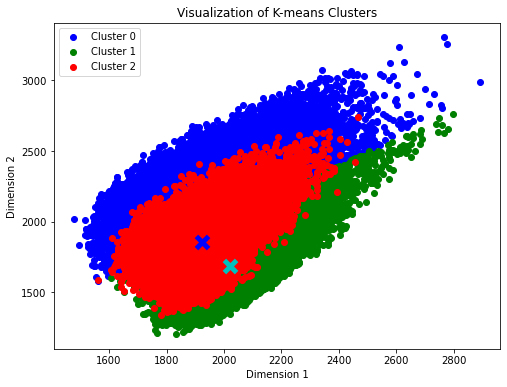

In [22]:
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'lime']
colors_centroid = ['r', 'c', 'b', 'g', 'm', 'y', 'k', 'purple', 'orange', 'lime']
clusters_colors = [colors[i] for i in clusters]
# plt.scatter(distances[:, 0], distances[:, 1], c=clusters_colors, label=f'Cluster {i}')

for cluster_index in range(n_clusters):
    cluster_points = distances[clusters == cluster_index]
    centroid_x = cluster_points[:, 0].mean()
    centroid_y = cluster_points[:, 1].mean()
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[cluster_index], label=f'Cluster {cluster_index}')
    plt.scatter(centroid_x,centroid_y,marker = "x", s=150,linewidths = 5, zorder = 10, c=colors_centroid[cluster_index])



plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Visualization of K-means Clusters')
plt.legend()
plt.show()

## Compression / Décompression

In [23]:
def compress_image(data, clusters, centers):
    compressed_image = np.zeros_like(data)
    for i in range(len(data)):
        compressed_image[i] = clusters[i]
    return compressed_image

def decompress_image(data, clusters, centers):
    decompressed_image = np.zeros_like(data)
    for i in range(len(data)):
        decompressed_image[i] = centers[int(clusters[i])]
    return decompressed_image

def kmeans_compress_decompress(data, k, max_iterations=100):
    clusters, centers = kmeans_star(data, k, max_iterations)
    compressed_image = compress_image(data, clusters, centers)
    decompressed_image = decompress_image(data, clusters, centers)
    return compressed_image, decompressed_image

In [24]:
image_index = 0
image = x_train_normalized[image_index]

# Convert the image to a flattened 1D array
image_flattened = image.flatten()

# Set the number of clusters for k-means compression
k = 10

# Perform compression and decompression
compressed_image, decompressed_image = kmeans_compress_decompress(image_flattened, k)

# Reshape the compressed and decompressed images back to the original dimensions
compressed_image = compressed_image.reshape(image.shape)
decompressed_image = decompressed_image.reshape(image.shape)

# Display the original, compressed, and decompressed images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Compressed image
plt.subplot(1, 3, 2)
plt.imshow(compressed_image, cmap='gray')
plt.title('Compressed Image')

# Decompressed image
plt.subplot(1, 3, 3)
plt.imshow(decompressed_image, cmap='gray')
plt.title('Decompressed Image')

plt.tight_layout()
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function argmin at 0x000002B1F075AB80>) found for signature:
 
 >>> argmin(float64)
 
There are 2 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload in function 'array_argmin': File: numba\np\arraymath.py: Line 654.
        With argument(s): '(float64)':[0m
[1m       Rejected as the implementation raised a specific error:
         AttributeError: 'Float' object has no attribute 'dtype'[0m
  raised from C:\Users\Maathess\AppData\Roaming\Python\Python39\site-packages\numba\np\arraymath.py:657
[0m
[0m[1mDuring: resolving callee type: Function(<function argmin at 0x000002B1F075AB80>)[0m
[0m[1mDuring: typing of call at C:\Users\Maathess\AppData\Local\Temp/ipykernel_8088/335785818.py (17)
[0m
[1m
File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_8088\335785818.py", line 17:[0m
[1m<source missing, REPL/exec in use?>[0m


In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(decompressed_image[0], cmap='gray')
plt.show()

In [ ]:
def plot_digits_with_Y(X, Y):
    """
    Afficher les 10 premiers chiffres de chaque chiffre
    """
    fig, axs = plt.subplots(10, 10, figsize=(5, 5))
    for digit in range(10):
        digit_indices = np.where(Y == digit)[0][:10]  # Sélectionner les indices des 10 premiers échantillons du chiffre
        for i, idx in enumerate(digit_indices):
            ax = axs[digit, i]
            ax.imshow(X[idx], cmap='gray')
            ax.axis('off')

In [ ]:
# Afficher les digits pour chaque cluster
fig, axs = plt.subplots(n_clusters, 10, figsize=(10, n_clusters))
fig.suptitle('Digits dans chaque cluster')

for i in range(n_clusters):
    cluster_digits = data[labels == i]
    for j in range(10):
        ax = axs[i, j]
        ax.imshow(cluster_digits[j].reshape(28, 28), cmap='gray')
        ax.axis('off')
plt.show()

In [ ]:
# Afficher les digits pour chaque cluster
fig, axs = plt.subplots(n_clusters, 10, figsize=(10, n_clusters))
fig.suptitle('Digits dans chaque cluster')

for i in range(n_clusters):
    cluster_digits = x_test[labels == i]
    for j in range(10):
        ax = axs[i, j]
        ax.imshow(cluster_digits[j].reshape(28, 28), cmap='gray')
        ax.axis('off')
plt.show()